In [2]:
from importlib import reload  
import panel as pn
pn.extension('tabulator')
import numpy as np
import plotly.express as px
from polarspike import Overview
import polars as pl
pn.extension()
pn.extension('plotly')
from polarspike import colour_template
from polarspike import spiketrain_plots
from polarspike import moving_bars
from polarspike import chirps
from polarspike import stimulus_spikes
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pandas as pd
from polarspike import plotly_templates
from polarspike import spiketrains
from polarspike import cells_and_stimuli
from polarspike import histograms
from polarspike import binarizer
import sys
import polarspike
from plotly.subplots import make_subplots
from bokeh.plotting import figure, show
from polarspike import quality_tests

# Here I show how the quality index can be calculated for any full field repeating stimulus
We begin by loading some recordings:

In [13]:
recordings = Overview.Recording_s.load_from_single(r"B:\Marvin\combined_analysis", "test_analysis", r"B:\Marvin\Zebrafish_20_11_23\ks_sorted\overview")

In [14]:
recordings.add_from_saved("B:\Marvin\Zebrafish_21_11_23\ks_sorted\overview")

Next, we define some dataframes containing only fff data:

In [15]:
recordings.dataframes["fff_quality"] = recordings.spikes_df.query("stimulus_name=='FFF'")
recordings.dataframes["fff_quality_stim"] = recordings.stimulus_df.query("stimulus_name=='FFF'")

In [16]:
recordings.analysis["fff_quality"] = {}
# Define the cell_df for this analysis
recordings.analysis["fff_quality"]["cell_df"] = "fff_quality"
# Define the stimulus_df
recordings.analysis["fff_quality"]["stimulus_df"] = "fff_quality_stim" 

Lets get some stats of the stimulus to see that everything is alright.

In [17]:
stimulus_spikes.stim_duration(recordings.dataframes["fff_quality_stim"], ["all"])

24.011604999999996

In [18]:
triggers = stimulus_spikes.mean_trigger_times(recordings.dataframes["stimulus_df"], ["all"])
triggers

array([2.0009475, 2.0009475, 2.00097  , 2.00097  , 2.00097  , 2.00097  ,
       2.00097  , 2.00097  , 2.000965 , 2.000965 , 2.00098  , 2.00098  ])

# Quality Index 
Let us first calculate the quality index for all responses and all recordings. So in this approach we calculate the index for a single cell over all full field flash stimuli shown to that cell combined.

Load the spikes for the analysis that we defined above.

In [19]:
spikes = recordings.spikes_for_analysis("fff_quality", pandas=False)

Run the quality index code:

In [20]:
results = quality_tests.spiketrain_qi(spikes, max_window=np.sum(triggers), max_repeat=triggers.shape[0])

In [21]:
results

,,qi
cell_index,recording,
0,zebrafish_20_11_23,0.092122
1,zebrafish_20_11_23,0.097873
2,zebrafish_20_11_23,0.092959
3,zebrafish_20_11_23,0.096245
4,zebrafish_20_11_23,0.091582
...,...,...
304,zebrafish_21_11_23,0.091828
305,zebrafish_21_11_23,0.093015
306,zebrafish_21_11_23,0.099068


Lets add the qi values to the original dataframe

In [27]:
df_temp = recordings.dataframes["fff_quality"].copy() # Create copy of the original
df_temp = df_temp.set_index(["cell_index", "recording"]) # Align indices
df_temp["qi"] = 0 # set all qis to 0
df_temp.update(results) #update qis
df_temp = df_temp.reset_index(drop=False)
df_temp

,cell_index,recording,stimulus_name,stimulus_index,nr_of_spikes,centres_x,centres_y,filter,qi
0,0,zebrafish_20_11_23,FFF,0,590,0.0,420.0,True,0.092122
1,0,zebrafish_20_11_23,FFF,5,2086,0.0,420.0,True,0.092122
2,1,zebrafish_20_11_23,FFF,0,0,0.0,60.0,True,0.097873
3,1,zebrafish_20_11_23,FFF,5,78,0.0,60.0,True,0.097873
4,2,zebrafish_20_11_23,FFF,0,73,0.0,60.0,True,0.092959
...,...,...,...,...,...,...,...,...,...
2265,310,zebrafish_21_11_23,FFF,0,0,NaN,NaN,True,0.000000
2266,310,zebrafish_21_11_23,FFF,5,0,NaN,NaN,True,0.000000
2267,310,zebrafish_21_11_23,FFF,14,0,NaN,NaN,True,0.000000
2268,310,zebrafish_21_11_23,FFF,16,0,NaN,NaN,True,0.000000


In [37]:
recordings.dataframes["fff_quality"] = df_temp

## Overview stat plots:

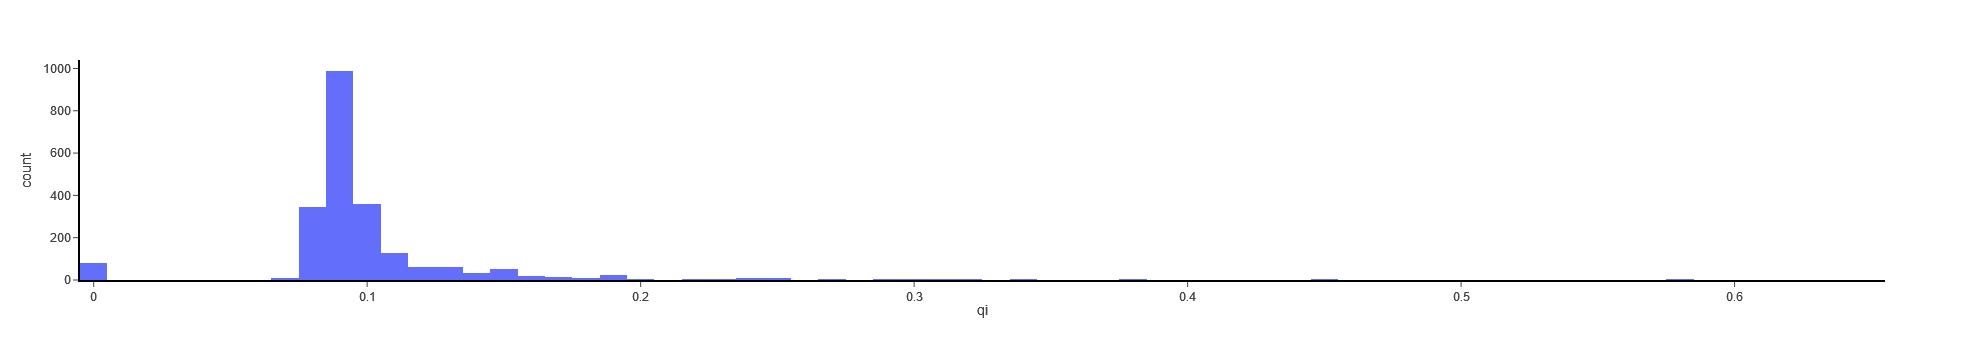

In [30]:
fig = px.histogram(df_temp, x="qi")
fig.update_layout(template="bar_template")
fig.show()

In [35]:
print(f"median = {np.median(df_temp['qi'])}, std = {np.std(df_temp['qi'])}")

median = 0.09097686307384432, std = 0.05641596229340573


Lets create a new dataframe with all cells with a qi of median+2*std

In [64]:
recordings.dataframes["fff_quality_filtered"] = recordings.dataframes["fff_quality"].query("qi > 0.1")

In [40]:
recordings.dataframes["fff_quality_filtered"]

,cell_index,recording,stimulus_name,stimulus_index,nr_of_spikes,centres_x,centres_y,filter,qi
12,6,zebrafish_20_11_23,FFF,0,328,60.0,270.0,True,0.109277
13,6,zebrafish_20_11_23,FFF,5,1137,60.0,270.0,True,0.109277
14,7,zebrafish_20_11_23,FFF,0,331,90.0,390.0,True,0.195459
15,7,zebrafish_20_11_23,FFF,5,26,90.0,390.0,True,0.195459
18,9,zebrafish_20_11_23,FFF,0,243,90.0,30.0,True,0.109345
...,...,...,...,...,...,...,...,...,...
2225,301,zebrafish_21_11_23,FFF,0,716,360.0,60.0,True,0.174995
2226,301,zebrafish_21_11_23,FFF,5,1364,360.0,60.0,True,0.174995
2227,301,zebrafish_21_11_23,FFF,14,576,360.0,60.0,True,0.174995
2228,301,zebrafish_21_11_23,FFF,16,501,360.0,60.0,True,0.174995


Lets look at these cells:

In [65]:
spikes = recordings.get_spikes_df("fff_quality_filtered")
spikes

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index,recording
0,6,7216.94075,0.55850,0,0,0.55850,5,zebrafish_20_11_23
1,6,7217.65115,1.26890,0,0,1.26890,5,zebrafish_20_11_23
2,6,7219.06155,2.67930,0,0,2.67930,5,zebrafish_20_11_23
3,6,7219.33690,2.95465,0,0,2.95465,5,zebrafish_20_11_23
4,6,7220.26900,3.88675,0,0,3.88675,5,zebrafish_20_11_23
...,...,...,...,...,...,...,...,...
469903,301,24838.84475,239.55080,5,9,23.44620,30,zebrafish_21_11_23
469904,301,24839.03825,239.74430,5,9,23.63970,30,zebrafish_21_11_23
469905,301,24839.31260,240.01865,5,9,23.91405,30,zebrafish_21_11_23
469906,301,24839.35830,240.06435,5,9,23.95975,30,zebrafish_21_11_23


In [41]:
CT = colour_template.Colour_template()
CT.pick_stimulus("FFF_6_MC")
plot_colours = CT.colours[::2]
names = CT.names[::2]

<span style="font-family: monospace">#fe7c7c <span style="color: #fe7c7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#fafe7c <span style="color: #fafe7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#8afe7c <span style="color: #8afe7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#7cfcfe <span style="color: #7cfcfe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#7c86fe <span style="color: #7c86fe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#fe7cfe <span style="color: #fe7cfe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span>

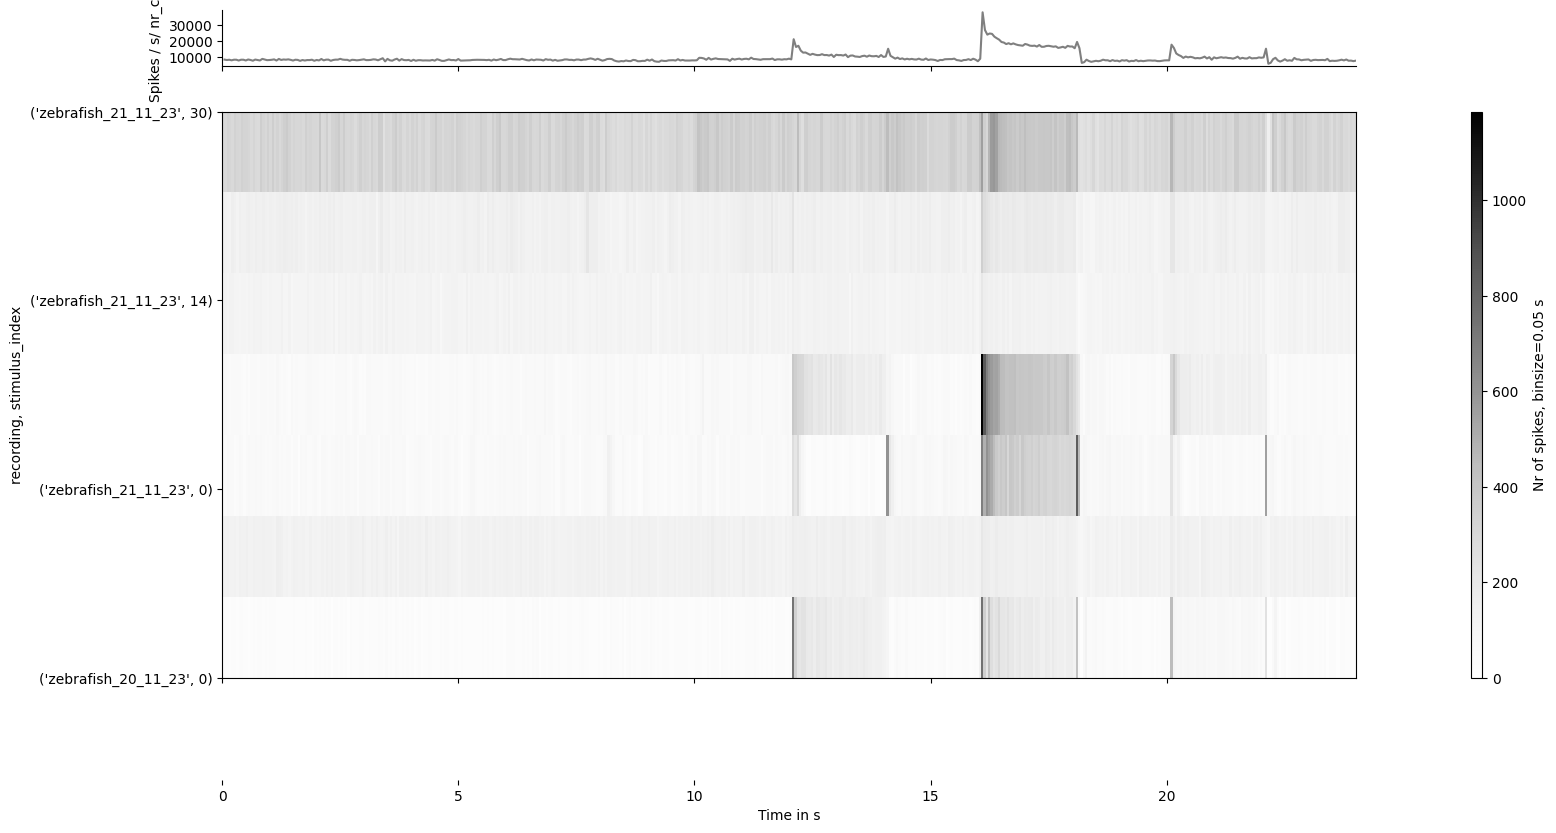

In [55]:
fig, ax = spiketrain_plots.whole_stimulus(spikes, stacked=True, indices=["recording", "stimulus_index"], width=18)
CT.add_stimulus_to_plot(fig)

We can also plot more detailed:

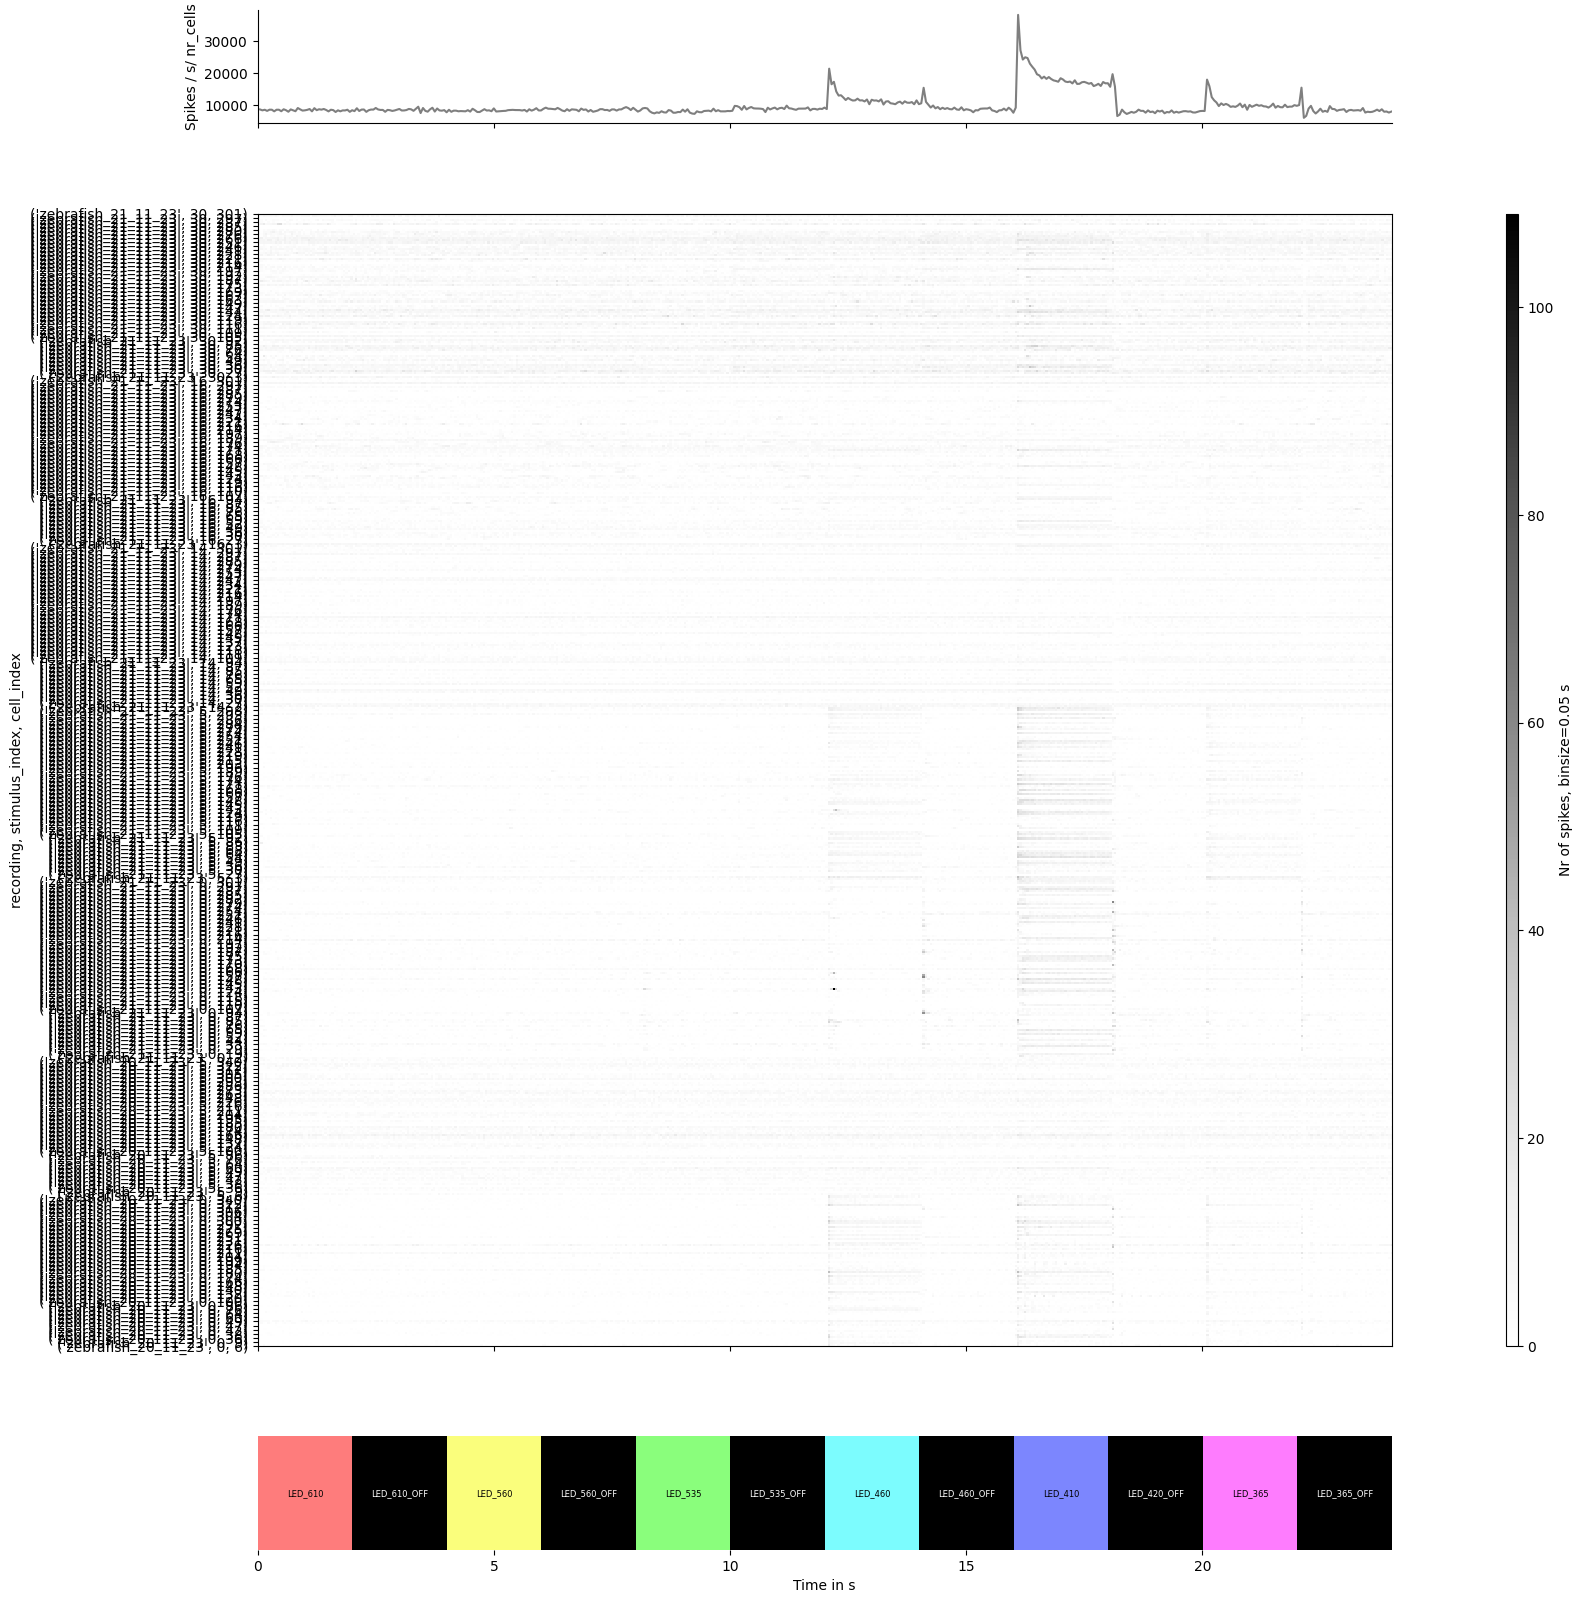

In [70]:
fig, ax = spiketrain_plots.whole_stimulus(spikes, stacked=True, indices=["recording", "stimulus_index", "cell_index"], width=18, height=20)
fig = CT.add_stimulus_to_plot(fig, triggers)

We can repeat the thresholding and filtering step and be more strict

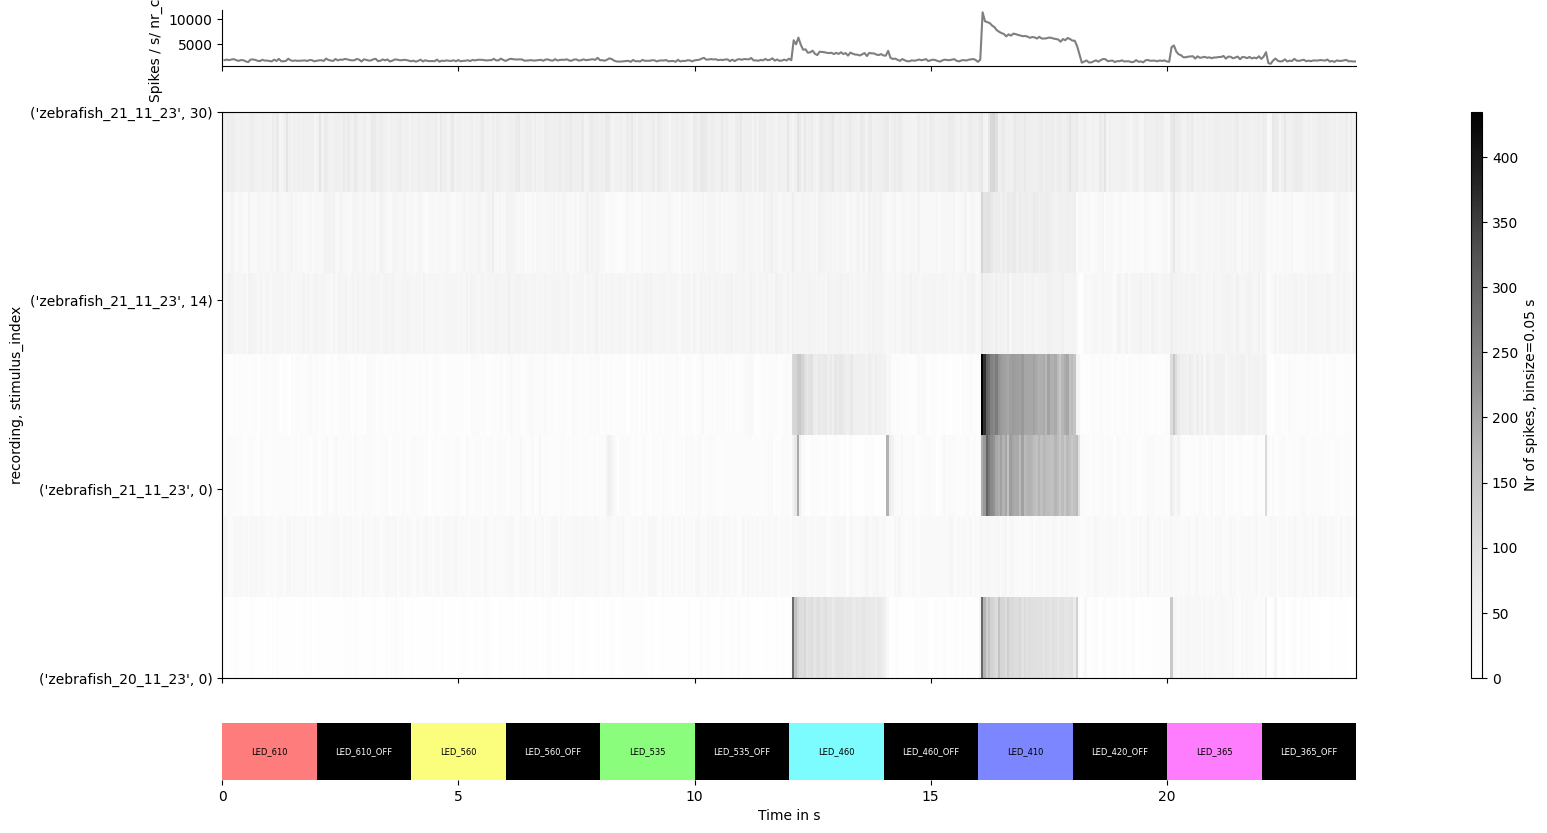

In [71]:
recordings.dataframes["fff_quality_filtered"] = recordings.dataframes["fff_quality"].query("qi > 0.15")
spikes = recordings.get_spikes_df("fff_quality_filtered")
fig, ax = spiketrain_plots.whole_stimulus(spikes, stacked=True, indices=["recording", "stimulus_index"], width=18)
fig = CT.add_stimulus_to_plot(fig, triggers)

We can also plot more detailed:

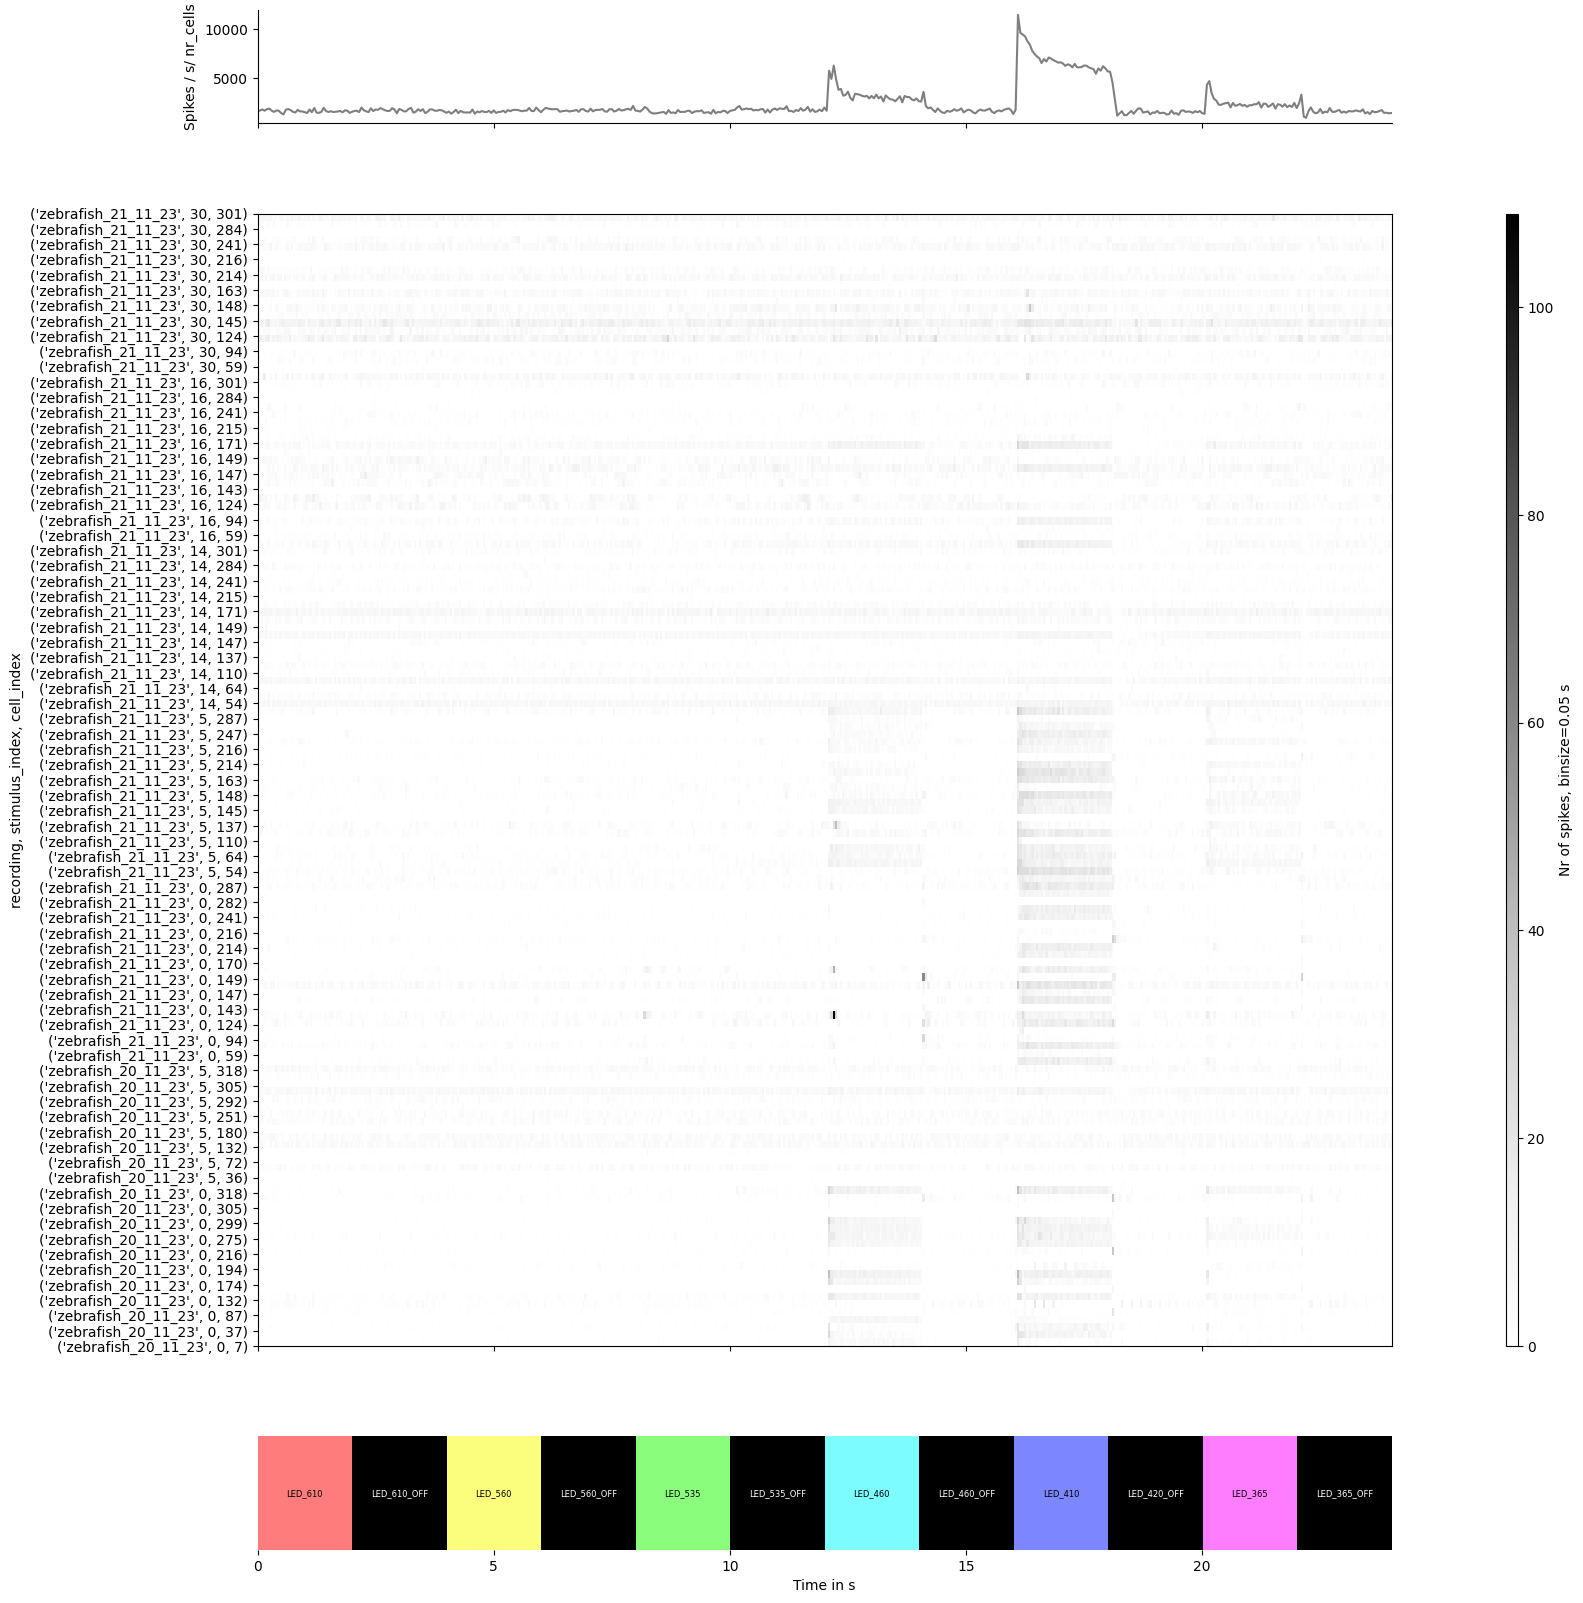

In [72]:
fig, ax = spiketrain_plots.whole_stimulus(spikes, stacked=True, indices=["recording", "stimulus_index", "cell_index"], width=18, height=20)
fig = CT.add_stimulus_to_plot(fig, triggers)